In [1]:
import time
from epftoolbox.evaluation import rMAE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from jupyterthemes import jtplot
from pywt import wavedec
import pywt
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set()

Importando los datos de precio de electricidad y precio del gas natural

In [2]:
datosraw = pd.read_csv('Gas_PML_Daily_2018_22.csv')

In [3]:
# Split data into train and test
data = datosraw.copy()
data = data.drop(columns=['Demanda','Fotovoltaica','Hidroelectrica','Eolica'])
data['Date'] =  pd.to_datetime(data['Date'],dayfirst=True)
data = data.set_index('Date')

train = data.loc[(data.index >= '2020-01-01') & (data.index <= '2021-12-31')]
test = data.loc[(data.index >= '2022-01-01') & (data.index <= '2022-12-31')]

In [4]:
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# trainscaled = scaler.fit_transform(train)
# testscaled  = scaler.fit_transform(test)

In [5]:
# # split into input and outputs
# train_X, train_y =  trainscaled[:, :-1], trainscaled[:, -1]
# test_X, test_y = testscaled[:, :-1], testscaled[:, -1]

# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [6]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    rmae = rMAE(actual, predicted, m=None, freq='1H')
    smape = 100/len(actual) * np.sum(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))
    return mape*100,mae,mse,rmse,smape,rmae

/////////////////////// MULTIVARIATE LSTM MODEL USING WAVELET DECOMPOSITION /////////////////////////////////////

Primero se descomponen las series de precio y gas en DWT para el periodo:
Train de 01/01/2020 al 31/12/2021
Test  de 01/01/2022 al 3/12/2022

In [7]:
train_MVDWT = train.copy()
test_MVDWT = test.copy()

In [8]:
coeffsMVDWT_Price = wavedec(data=train_MVDWT['Precio Electricidad'], wavelet='db5', level=5)
cA5_trainPrice, cD5_trainPrice, cD4_trainPrice, cD3_trainPrice, cD2_trainPrice, cD1_trainPrice = coeffsMVDWT_Price

coeffsMVDWT_Gas = wavedec(data=train_MVDWT['Precio Gas'], wavelet='db5', level=5)
cA5_trainGas, cD5_trainGas, cD4_trainGas, cD3_trainGas, cD2_trainGas, cD1_trainGas = coeffsMVDWT_Gas

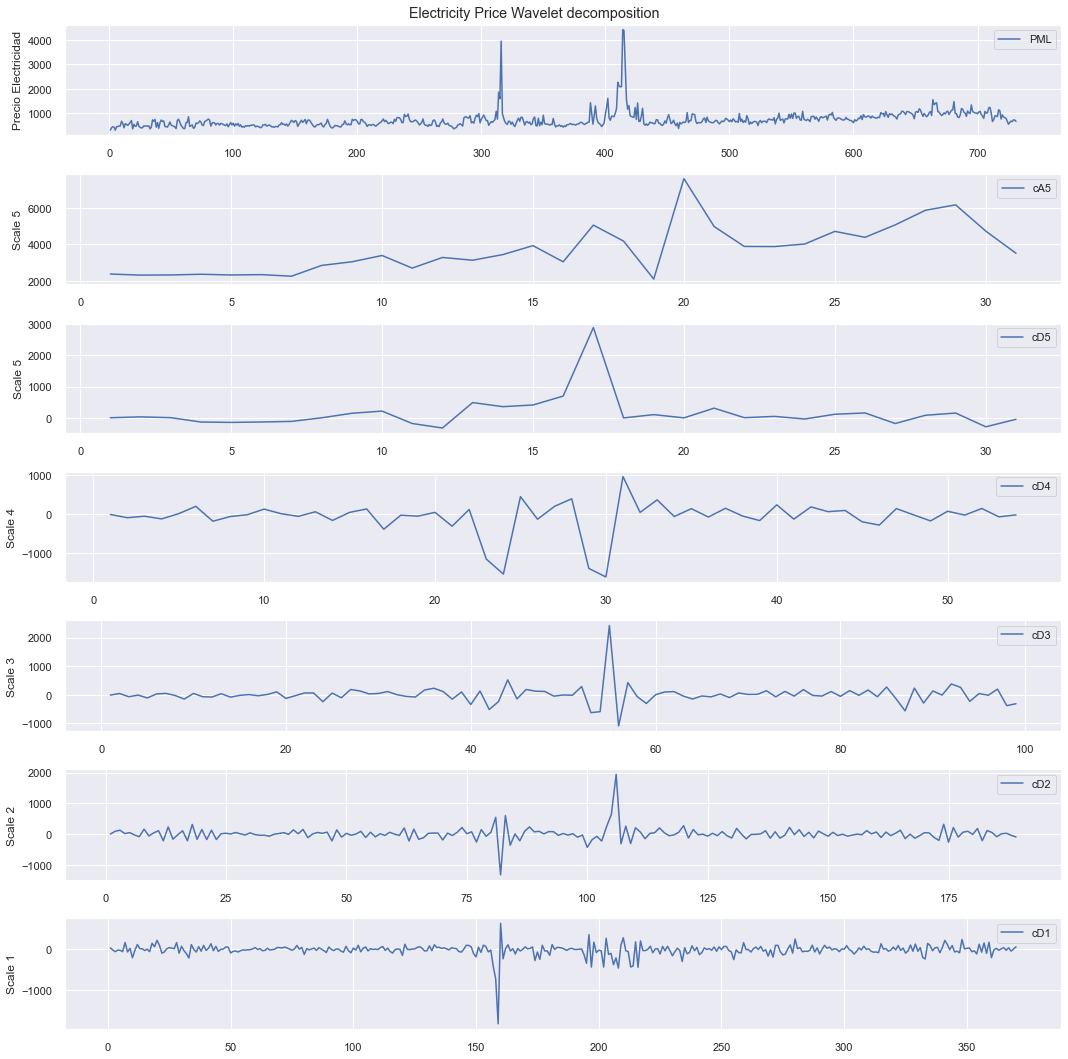

In [9]:
xscalePML_MVDWT = np.arange(1,len(train_MVDWT)+1,1)
xscalecA5_cD5trainPrice = np.arange(1,len(cA5_trainPrice)+1,1)
xscalecD5trainPrice = np.arange(1,len(cD5_trainPrice)+1,1)
xscalecD4trainPrice = np.arange(1,len(cD4_trainPrice)+1,1)
xscalecD3trainPrice = np.arange(1,len(cD3_trainPrice)+1,1)
xscalecD2trainPrice = np.arange(1,len(cD2_trainPrice)+1,1)
xscalecD1trainPrice = np.arange(1,len(cD1_trainPrice)+1,1)

fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(7,figsize=(15,15))
fig.suptitle('Electricity Price Wavelet decomposition')
sns.lineplot(ax=ax0,x=xscalePML_MVDWT,y=train_MVDWT['Precio Electricidad'],label='PML')
sns.lineplot(ax=ax1,x=xscalecA5_cD5trainPrice,y=cA5_trainPrice,label='cA5').set(ylabel = "Scale 5")
sns.lineplot(ax=ax2,x=xscalecA5_cD5trainPrice,y=cD5_trainPrice,label='cD5').set(ylabel = "Scale 5")
sns.lineplot(ax=ax3,x=xscalecD4trainPrice,y=cD4_trainPrice,label='cD4').set(ylabel = "Scale 4")
sns.lineplot(ax=ax4,x=xscalecD3trainPrice,y=cD3_trainPrice,label='cD3').set(ylabel = "Scale 3")
sns.lineplot(ax=ax5,x=xscalecD2trainPrice,y=cD2_trainPrice,label='cD2').set(ylabel = "Scale 2")
sns.lineplot(ax=ax6,x=xscalecD1trainPrice,y=cD1_trainPrice,label='cD1').set(ylabel = "Scale 1")
ax1.legend(loc='upper right')
#plt.savefig('Fig6_EP_DWT',format='pdf',dpi=600)
plt.tight_layout()

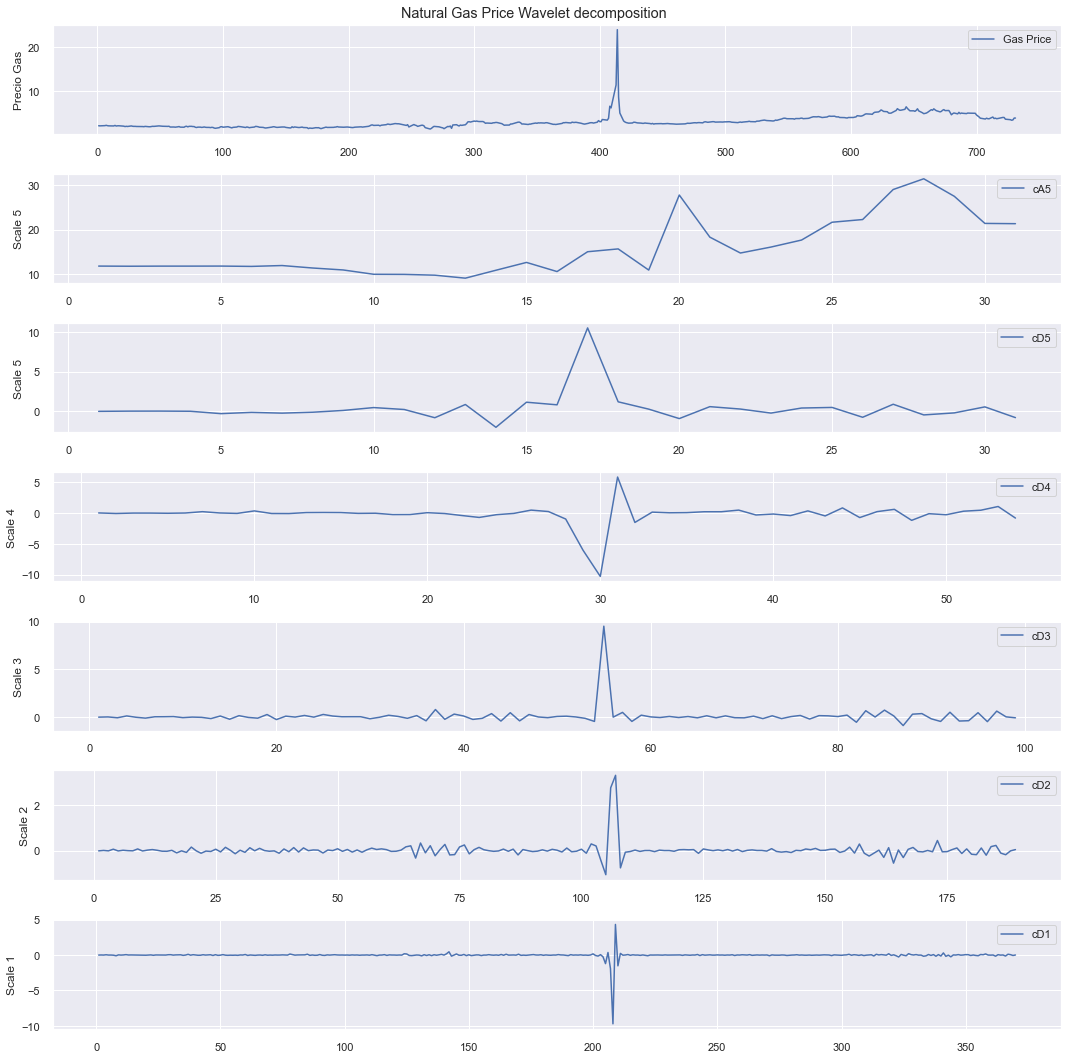

In [10]:
xscaleGas_MVDWT = np.arange(1,len(train_MVDWT)+1,1)
xscalecA5_cD5trainGas = np.arange(1,len(cA5_trainGas)+1,1)
xscalecD4trainGas = np.arange(1,len(cD4_trainGas)+1,1)
xscalecD3trainGas = np.arange(1,len(cD3_trainGas)+1,1)
xscalecD2trainGas = np.arange(1,len(cD2_trainGas)+1,1)
xscalecD1trainGas = np.arange(1,len(cD1_trainGas)+1,1)

fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(7,figsize=(15,15))
fig.suptitle('Natural Gas Price Wavelet decomposition')
sns.lineplot(ax=ax0,x=xscaleGas_MVDWT,y=train_MVDWT['Precio Gas'],label='Gas Price')
sns.lineplot(ax=ax1,x=xscalecA5_cD5trainGas,y=cA5_trainGas,label='cA5').set(ylabel = "Scale 5")
sns.lineplot(ax=ax2,x=xscalecA5_cD5trainGas,y=cD5_trainGas,label='cD5').set(ylabel = "Scale 5")
sns.lineplot(ax=ax3,x=xscalecD4trainGas,y=cD4_trainGas,label='cD4').set(ylabel = "Scale 4")
sns.lineplot(ax=ax4,x=xscalecD3trainGas,y=cD3_trainGas,label='cD3').set(ylabel = "Scale 3")
sns.lineplot(ax=ax5,x=xscalecD2trainGas,y=cD2_trainGas,label='cD2').set(ylabel = "Scale 2")
sns.lineplot(ax=ax6,x=xscalecD1trainGas,y=cD1_trainGas,label='cD1').set(ylabel = "Scale 1")
ax1.legend(loc='upper right')
#plt.savefig('Fig7_NGP_DWT',format='pdf',dpi=600)
plt.tight_layout()

Reconstruyendo las series de tiempo de la electricidad y el gas eliminando la última componente (cD1) correspondiente al ruido en cada una de las series

In [11]:
cA5_PriceDWT = cA5_trainPrice.copy()
cD5_PriceDWT = cD5_trainPrice.copy()
cD4_PriceDWT = cD4_trainPrice.copy()
cD3_PriceDWT = cD3_trainPrice.copy()
cD2_PriceDWT = cD2_trainPrice.copy()
cD1_PriceDWT = cD1_trainPrice.copy()

cD1_trainPrice2 = np.zeros((cD1_PriceDWT.shape[0],), dtype=int) # Ponendo en ceros este coeficiente para ignorarlo durante reconstrucción
coeffselectedPrice = [cA5_PriceDWT,cD5_PriceDWT, cD4_PriceDWT,cD3_PriceDWT,cD2_PriceDWT,cD1_trainPrice2]
reconstructionPrice = pywt.waverec(coeffselectedPrice, wavelet='db5')

In [12]:
cA5_GasDWT = cA5_trainGas.copy()
cD5_GasDWT = cD5_trainGas.copy()
cD4_GasDWT = cD4_trainGas.copy()
cD3_GasDWT = cD3_trainGas.copy()
cD2_GasDWT = cD2_trainGas.copy()
cD1_GasDWT = cD1_trainGas.copy()

cD1_trainGas2 = np.zeros((cD1_GasDWT.shape[0],), dtype=int) # Ponendo en ceros este coeficiente para ignorarlo durante reconstrucción

coeffselectedGas = [cA5_GasDWT,cD5_GasDWT,cD4_GasDWT,cD3_GasDWT,cD2_GasDWT,cD1_trainGas2]
reconstructionGas = pywt.waverec(coeffselectedGas, wavelet='db5')

In [13]:
train_MVDWTreconst = train.copy()
train_MVDWTreconst ['Precio Electricidad'] = reconstructionPrice[0:len(train_MVDWT)]
train_MVDWTreconst ['Precio Gas'] = reconstructionGas[0:len(train_MVDWT)]

Normalizando las dos series de tiempo y preparando los datos para el entrenamiento y prueba con LSTM

In [14]:
scaler2 = StandardScaler()
train_DWT2 = scaler2.fit_transform(train_MVDWTreconst)
test_DWT2  = scaler2.fit_transform(test_MVDWT)

In [15]:
# split into input and outputs
train_XMVDWT, train_yMVDWT =  train_DWT2[:, :-1], train_DWT2[:, -1]
test_XMVDWT, test_yMVDWT = test_DWT2[:, :-1], test_DWT2[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_XMVDWT = train_XMVDWT.reshape((train_XMVDWT.shape[0], 1, train_XMVDWT.shape[1]))
test_XMVDWT = test_XMVDWT.reshape((test_XMVDWT.shape[0], 1, test_XMVDWT.shape[1]))
print(train_XMVDWT.shape, train_yMVDWT.shape, test_XMVDWT.shape, test_yMVDWT.shape)

(731, 1, 1) (731,) (365, 1, 1) (365,)


Entrenando red neuronal LSTM

Epoch 1/100
46/46 - 2s - loss: 0.9857 - val_loss: 0.8639 - 2s/epoch - 54ms/step
Epoch 2/100
46/46 - 0s - loss: 0.8511 - val_loss: 0.7817 - 142ms/epoch - 3ms/step
Epoch 3/100
46/46 - 0s - loss: 0.7555 - val_loss: 0.7053 - 150ms/epoch - 3ms/step
Epoch 4/100
46/46 - 0s - loss: 0.6629 - val_loss: 0.6327 - 145ms/epoch - 3ms/step
Epoch 5/100
46/46 - 0s - loss: 0.5962 - val_loss: 0.5692 - 125ms/epoch - 3ms/step
Epoch 6/100
46/46 - 0s - loss: 0.5195 - val_loss: 0.5194 - 134ms/epoch - 3ms/step
Epoch 7/100
46/46 - 0s - loss: 0.4726 - val_loss: 0.4876 - 131ms/epoch - 3ms/step
Epoch 8/100
46/46 - 0s - loss: 0.4425 - val_loss: 0.4694 - 135ms/epoch - 3ms/step
Epoch 9/100
46/46 - 0s - loss: 0.4427 - val_loss: 0.4602 - 133ms/epoch - 3ms/step
Epoch 10/100
46/46 - 0s - loss: 0.4334 - val_loss: 0.4560 - 113ms/epoch - 2ms/step
Epoch 11/100
46/46 - 0s - loss: 0.4254 - val_loss: 0.4535 - 117ms/epoch - 3ms/step
Epoch 12/100
46/46 - 0s - loss: 0.4266 - val_loss: 0.4516 - 120ms/epoch - 3ms/step
Epoch 13/100
46

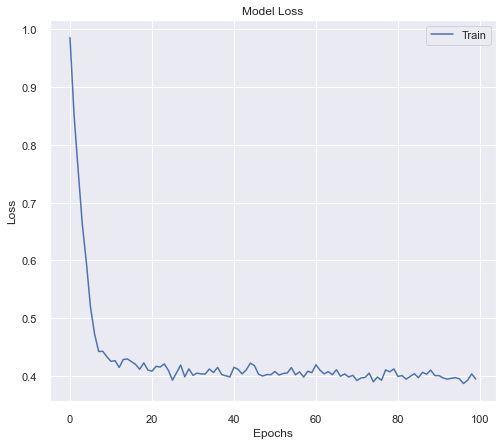

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras.layers import Bidirectional
from keras.layers import Dropout

# Estableciendo random seed para hacer que los resultados sean reproducibles
np.random.seed(4321)
tf.random.set_seed(4321)

model2 = Sequential()
model2.add(Bidirectional(LSTM(50, activation='linear', input_shape=(train_XMVDWT.shape[1], train_XMVDWT.shape[2]))))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=2))
model2.compile(optimizer='adam', loss='mse')

history_model2 = model2.fit(train_XMVDWT, train_yMVDWT, epochs=100, batch_size=16, validation_data=(test_XMVDWT, test_yMVDWT), verbose=2, shuffle=False)
plt.plot(history_model2.history['loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'])

In [17]:
y_predtestMVDWT = model2.predict(test_XMVDWT)
invertedtestMVDWT = scaler2.inverse_transform(y_predtestMVDWT)

In [18]:
xscaletestMVDWT = np.arange(1,len(test_XMVDWT)+1,1)

In [19]:
testdf_MVDWT = test_MVDWT.copy()
testdf_MVDWT = testdf_MVDWT.drop(columns=['Precio Gas'])
testdf_MVDWT['Prediction'] = invertedtestMVDWT[:,0]

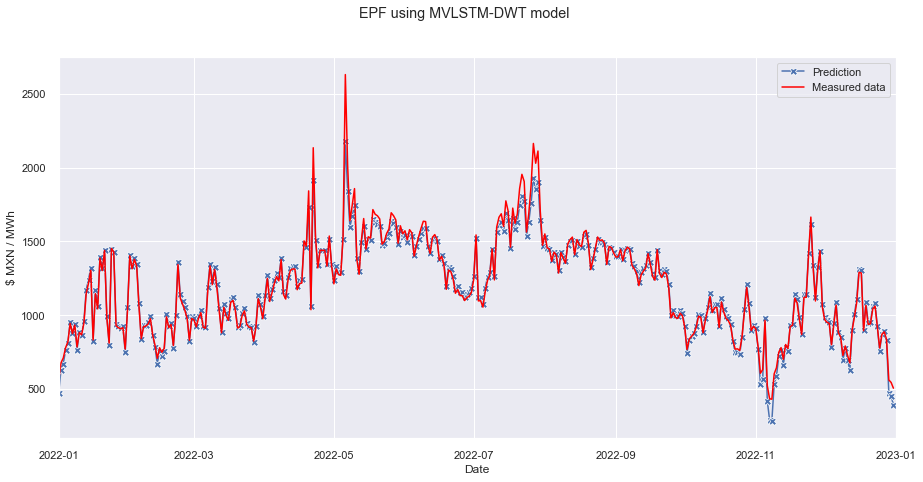

In [20]:
import datetime
fig, (ax1) = plt.subplots(figsize=(15,7))
fig.suptitle('EPF using MVLSTM-DWT model')
sns.lineplot(ax=ax1,x=testdf_MVDWT.index,y=testdf_MVDWT['Prediction'],label='Prediction',marker = 'X',markersize=7).set(ylabel = "$ MXN / MWh")
sns.lineplot(ax=ax1,x=testdf_MVDWT.index,y=testdf_MVDWT['Precio Electricidad'],label='Measured data', color='red')
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])
ax1.legend(loc='upper right')
#plt.savefig('D:\\Users\\jorge\\Documents\\UAZ\\Proyectos Investigacion\\PI_2022\\Proyecto_SEN_CENACE\\Para articulo\\Figuras\\Fig26_LSTM_MultivariateDWT',dpi=300)

In [21]:
testdf_MVDWT = testdf_MVDWT.asfreq('d')

In [22]:
pd.options.display.float_format = '{:.2f}'.format
modeloLSTMMVDWT = pd.DataFrame(data=calculate_model_accuracy_metrics(testdf_MVDWT['Precio Electricidad'],testdf_MVDWT['Prediction']), index=['MAPE', 'MAE','MSE','RMSE','SMAPE','rMAE'])
modeloLSTMMVDWT.columns = ['Modelo LSTM Multivariable DWT']
modeloLSTMMVDWT

,Modelo LSTM Multivariable DWT
MAPE,2.31
MAE,26.10
MSE,2146.11
RMSE,46.33
SMAPE,2.39
rMAE,0.21


In [23]:
def lstm():
    """
    Bi-directional LSTM model
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='linear', input_shape=(train_XMVDWT.shape[1], train_XMVDWT.shape[2]))))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=2))
    model.compile(optimizer='adam', loss='mse')
    return model

In [24]:
from sklearn.model_selection import train_test_split

# Split your training data into a proper training set and a calibration set
train_XMVDWT_proper, train_XMVDWT_calib, train_yMVDWT_proper, train_yMVDWT_calib = train_test_split(train_XMVDWT, train_yMVDWT, test_size=0.3, random_state=42)

# Train the LSTM model on the proper training set
lstm_model = lstm()
lstm_model.fit(train_XMVDWT_proper, train_yMVDWT_proper, epochs=100, batch_size=16)

# Compute nonconformity scores for the calibration set
predictions_calib = lstm_model.predict(train_XMVDWT_calib)
residuals_calib = np.abs(predictions_calib[:,0] - train_yMVDWT_calib)
sorted_residuals_calib = np.sort(residuals_calib, axis=0)

def conformal_prediction_interval(model, instance, alpha=0.05):
    """
    Compute the conformal prediction interval for a given instance.
    """
    prediction = model.predict(instance)
    residual = np.abs(prediction - instance)
    
    # Find the index for the alpha-level quantile
    index = int((1 - alpha) * len(sorted_residuals_calib))
    interval_radius = sorted_residuals_calib[index]
    
    return prediction - interval_radius, prediction + interval_radius

# Compute prediction intervals for the test set
lower_bounds, upper_bounds = [], []
for instance in test_XMVDWT:
    lb, ub = conformal_prediction_interval(lstm_model, instance)
    lower_bounds.append(lb)
    upper_bounds.append(ub)


Epoch 1/100


32/32 [==============================] - 2s 2ms/step - loss: 0.9669
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8256
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6767
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.5729
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4970
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4423
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4353
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4482
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4351
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4241
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4223
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4252
Epoch 13/100
32/32 [=============================

In [25]:
LB_LSTM = np.array(lower_bounds)
UB_LSTM = np.array(upper_bounds)

In [26]:
unscaled_pred_DWT = scaler2.inverse_transform(y_predtestMVDWT)
unscaled_pred_lowlim_DWT = scaler2.inverse_transform(LB_LSTM[:,0])
unscaled_pred_uplim_DWT = scaler2.inverse_transform(UB_LSTM[:,0])

final_unscaled_DWT = test.copy()
final_unscaled_DWT['pred'] = unscaled_pred_DWT[:,0]
final_unscaled_DWT['pred_uplim'] = unscaled_pred_uplim_DWT[:,0]
final_unscaled_DWT['pred_lowlim'] = unscaled_pred_lowlim_DWT[:,0]

(18993.0, 19357.0)

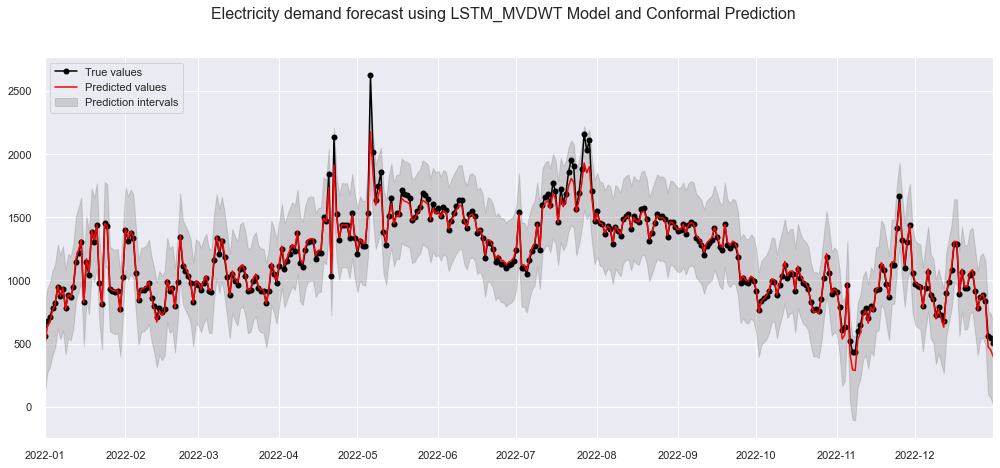

In [27]:
fig, (ax1) = plt.subplots(figsize=(17,7),sharex=True)
fig.suptitle('Electricity demand forecast using LSTM_MVDWT Model and Conformal Prediction', fontsize=16)
ax1.plot(final_unscaled_DWT.index, final_unscaled_DWT['Precio Electricidad'], marker='o', label="True values", color='black')
ax1.plot(final_unscaled_DWT.index, final_unscaled_DWT['pred'].values, label="Predicted values", color='red')
ax1.fill_between(
    final_unscaled_DWT.index,
    final_unscaled_DWT['pred_uplim'].values,
    final_unscaled_DWT['pred_lowlim'].values,
    alpha=0.3,
    label="Prediction intervals",
    color='gray'
)
ax1.legend(loc='upper left')
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2022,12,31)])
#plt.savefig('Fig11_EPF_LSTM',format='pdf',dpi=600)

In [28]:
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)

coverage = regression_coverage_score(final_unscaled_DWT['Precio Electricidad'].values,
            final_unscaled_DWT['pred_lowlim'].values, 
            final_unscaled_DWT['pred_uplim'].values)
width = regression_mean_width_score(final_unscaled_DWT['pred_lowlim'].values, final_unscaled_DWT['pred_uplim'].values)

In [30]:
pd.options.display.float_format = '{:.3f}'.format
PI_display = pd.DataFrame(data=(coverage, width), index=['Coverage', 'Width'])
PI_display.columns = ['Modelo LSTM_MVDWT_CP']
PI_display

,Modelo LSTM_MVDWT_CP
Coverage,0.997
Width,665.834
